# Visualization Building Blocks

in this notebook you will learn the intuition behind the features of the interpretability framework and how to us them.

## Layer Activation Mappings with AlexNet

Demonstration of visualizing layer attribution, the activation mapping  between two specified layers and their splits.

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

import data_utils
from data_utils import DataConfig
from midnite.common import Flatten
from plot_utils import *
from PIL import Image
from midnite import get_device
from midnite.visualization.base import *

import torch
from torch import Tensor
from torch.nn import Softmax
from torch.nn.modules import Sequential
from torch.nn.functional import interpolate
from torchvision import models

/home/fabian/Projects/midnite/src


## Step 1: Load pretrained model

In our example we use a pretrained ResNet for demonstration.

In [2]:
model = models.alexnet(pretrained=True)

model.eval()
model.to(get_device());

## Step 2: Load Image

In [3]:
input_ = data_utils.get_example_from_path("../data/imagenet_example_283.jpg", DataConfig.ALEX_NET)

## Layer attribution mapping
<img src="resources/saliencies_gradCAM.png">

## Step 3: Select Layer of Interest

in AlexNet there are 3 main layers (feature, avgpool and classification). For visualization we are interested in the feature layers, which consist of 13 layers. 
**Note: choose layers between 0 and 12 for AlexNet**

for example: we select layer number 6 as single layer (selected_layer) and want to compute its attribution to layer number 10 (output_layer).

In [4]:
selected_input_layer = 6
selected_output_layer = 10

### Split the Model into base_layers and inspection_layers
splitting the model with classification returns a list of base layers up to the selected single layer and the list of layers (inspection layers) from the selected layer until the specified output layer.

In [5]:
base_layers = list(model.features.children())[:selected_input_layer]
inspection_layers = list(model.features.children())[selected_input_layer:selected_output_layer+1]

## Step 4: Specify Layer Selectors
in this example we want to analyze the attribution of the selected layer 6 to layer 10. In other words, we want to know how much the features of layer 6 contributed to the output of layer 10, or more precisely, how much the they contributed to the top-layer-selection of layer 10.

For the inspection of a neuron value in the output, we use a top-layer-selector choosing the neuron of choice from a Neuronsplit of the output.

Additionally, a bottom_layer_split can be chosen. A SpatialSplit() gives the activations for each spatial position, which can be interpolated to the original image size and hence, be plotted onto the image. A NeuronSplit() as bottom_laye

**!!Please Note: 
the bottom_layer_selector needs to be an appropriate split for the selected_input_layer, 
and top_layer_selector needs to be an appropriate split for the selected_output_layer.**

In [6]:
top_layer_selector = SplitSelector(NeuronSplit(), [0, 0, 0])
bottom_layer_split = SpatialSplit()

## Step 5: Compute Saliency

### bottom layer SpacialSplit with top layer NeuronSelector
Computing the saliency for the first neuron of layer 6 (NeuronSplit [0, 0, 0]) with respect to the spatial dimensions of layer 10 (SpatialSplit). We can see that this neuron detects the right eye of the cat.

In [7]:
# Pooling operations loose 10 pixels on each side
def upsample(img, target):
    return interpolate(
        img.unsqueeze(dim=0).unsqueeze(dim=0), 
        size=target.size()[2:],
        mode='bilinear',
        align_corners=True
    ).squeeze(0).squeeze(0)

In [8]:
# select splits of interest
top_layer_selector = SplitSelector(ChannelSplit(), [0])
bottom_layer_split = SpatialSplit()

# split model into base_layers and inspection layers
base_layers = list(model.features.children())[:3]
inspection_layers = list(model.features.children())[3: 13] #slice indexing is [i: j-1]

## Example 3 : How to gain insight from bottom-layer-splits (Steps 3-6)
Here we investigate the activations of layer 6 with respect to the first neuron in layer 10.

### 1) bottom-layer channel split 
First, a channel split of the bottom-layer should reveal the most activated channels for this output neuron.

In [9]:
# select layers of interest and split model into base_layers and inspection layers
base_layers = list(model.features.children())[:6]
inspection_layers = list(model.features.children())[6: 11] #slice indexing is [i: j-1]

# select splits of interest
top_layer_selector = SplitSelector(NeuronSplit(), [0, 0, 0])
bottom_layer_split = ChannelSplit()

### 2) bottom-layer neuron split
Now let's look into these channels in greater detail and retrieve a neuron split on layer 6 and select one of the above max channels. Here we use the most active channel: #7.

In [10]:
# new bottom layer split, as we now want to retrieve the neuron activations with fixed channel 7
bottom_layer_split = NeuronSplit()

## Example 4: Guided Backpropagation of the input image w.r.t. the class score

100%|██████████| 450/450 [00:46<00:00,  9.58it/s]


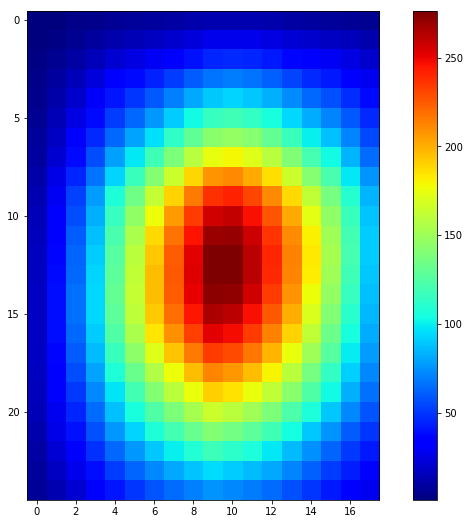

In [11]:
from midnite.visualization.base import Occlusion

heatmap = Occlusion(model, SplitSelector(NeuronSplit(), [283]), SpatialSplit(), chunk_size=(1, 10, 10), stride_length=(1, 20, 20)).visualize(input_)
show_heatmap(heatmap[0], 1.5)

torch.Size([1, 3, 500, 375])


100%|██████████| 20750/20750 [35:23<00:00,  9.77it/s] 


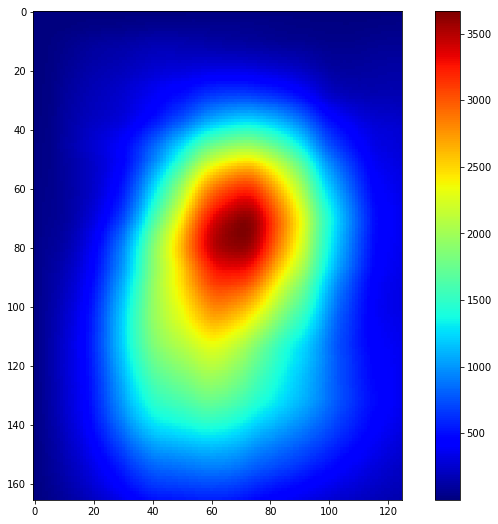

In [12]:
from midnite.visualization.base import Occlusion

print(input_.size())

heatmap = Occlusion(model, SplitSelector(NeuronSplit(), [283]), SpatialSplit(), chunk_size=(1, 41, 41), stride_length=(1, 3, 3)).visualize(input_)
show_heatmap(heatmap[0], 1.5, input_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


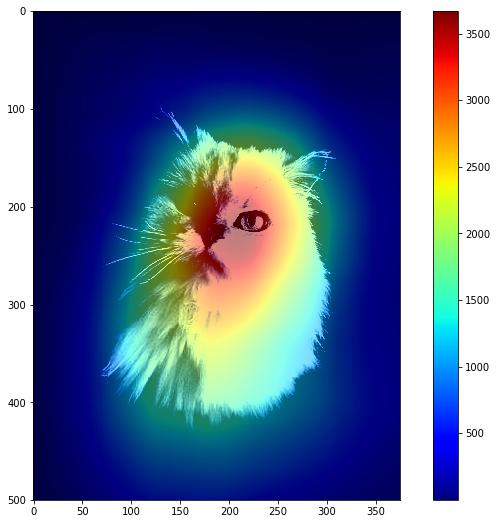

In [14]:
show_heatmap(upsample(heatmap[0], input_), 1.5, input_)